# Notebook 01 - Exploring the Synthetic CLD dataset

This notebook validates that the synthetic Cell Line Development (CLD) dataset generated by 'generate_synthetic_cld.py' behaves realistically and is suitable for downstream machine learning experiments.

The goal is not modeling yet, but to confirm that:
- Data size and structure match expectations
- Productivity, growth, viability, and quality trends resemble real CLD behavior
- Stability labels are reasonable and interpretable
- Batch effects and noise exist but do not dominate the signal

If this notebook looks reasonable, we can confidently proceed to feature engineering and ML modeling.

## 1) Import & DB connection

We import standard analysis libraries and connect to the SQLite database created by the synthetic CLD data generator.

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DB_PATH = "../data/synthetic/raw/cld.db"
conn = sqlite3.connect(DB_PATH)

print("Connected to:", DB_PATH)

Connected to: ../data/synthetic/raw/cld.db


## 2) Table row count sanity check

Expected (approximately):
- 500 clones
- 500 x 30 = 15,000 passages
- 15,000 x 4 ≈ 60,000 assay rows
- 500 stability labels
- 30 assay batches

In [3]:
tables = [
    "product","host_cell","vector","cell_line",
    "batch","clone","passage","process_condition",
    "assay_result","stability_test"
]

for t in tables:
    n = pd.read_sql_query(f"SELECT COUNT(*) AS n FROM {t}", conn)["n"][0]
    print(f"{t:16s} {n}")

product          1
host_cell        1
vector           1
cell_line        1
batch            30
clone            500
passage          15000
process_condition 15000
assay_result     60000
stability_test   500


## 3) Build an analysis table by joining assays with passage metadata

'assay_result' contains measured values (titer/VCD/viability/aggregation) per passage.
'passage' contains contextual metadata (clond_id, passage_number, phase).

We JOIN these tables on 'passage_id' to create a single analysis-ready table.

In [4]:
assay = pd.read_sql_query("""
SELECT 
  ar.assay_id,
  ar.assay_type,
  ar.value,
  ar.unit,
  ar.method,
  ar.batch_id,
  p.clone_id,
  p.passage_number,
  p.phase
FROM assay_result ar
JOIN passage p
  ON p.passage_id = ar.passage_id
""", conn)

assay.head()

,assay_id,assay_type,value,unit,method,batch_id,clone_id,passage_number,phase
0,ASSAY_CLONE_0001_P01_titer,titer,2.889395e+00,g/L,ELISA,B_P01,CLONE_0001,1,early
1,ASSAY_CLONE_0001_P01_vcd,vcd,9.043899e+06,cells/mL,Vi-CELL,B_P01,CLONE_0001,1,early
2,ASSAY_CLONE_0001_P01_viability,viability,9.377135e+01,%,Vi-CELL,B_P01,CLONE_0001,1,early
3,ASSAY_CLONE_0001_P01_aggregation,aggregation,8.058368e+00,%,SEC-HPLC,B_P01,CLONE_0001,1,early
4,ASSAY_CLONE_0001_P02_titer,titer,2.846536e+00,g/L,ELISA,B_P02,CLONE_0001,2,early


## 4) Sample a small set of clones for visualization

We randomly select a few clones to visually inspect CLD trends.
Plotting all 500 clones at once would be overwhelming.

In [5]:
all_clones = assay["clone_id"].unique()
np.random.seed(42)  # reproducibility
sample_clones = np.random.choice(all_clones, size=6, replace=False)
sample_clones

array(['CLONE_0362', 'CLONE_0074', 'CLONE_0375', 'CLONE_0156',
       'CLONE_0105', 'CLONE_0395'], dtype=object)

## 5) Titer vs passage (productivity trend)

Titer is a key CLD readout. (e.g., ELISA/Octect)
We expect:
- different clones to have different baseline titers
- many clones to show decreasing titer across passages depending on stability.

Fix the y-axis using global 1%-99% quantiles to enable fair comparison.

Fixed y-axis (titer) using 1%–99% quantiles: 0.000 to 7.813 g/L


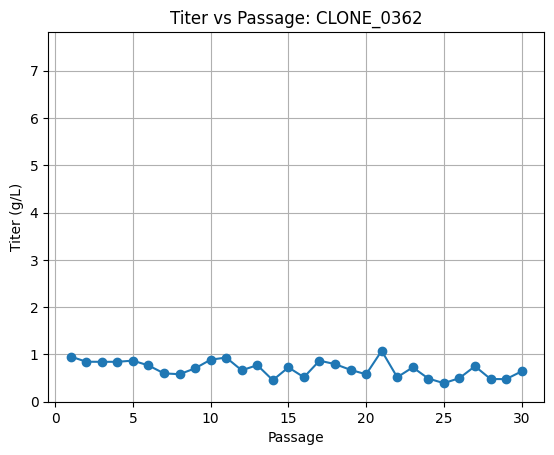

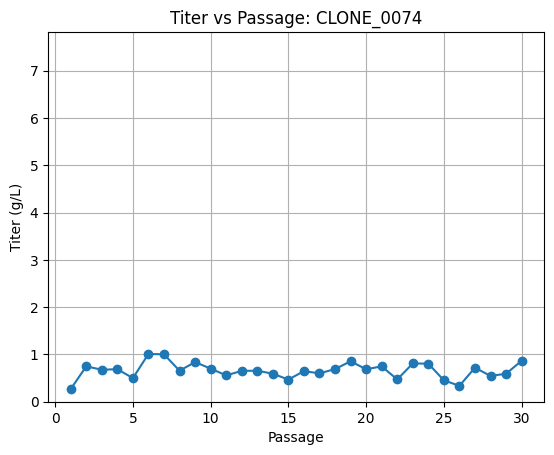

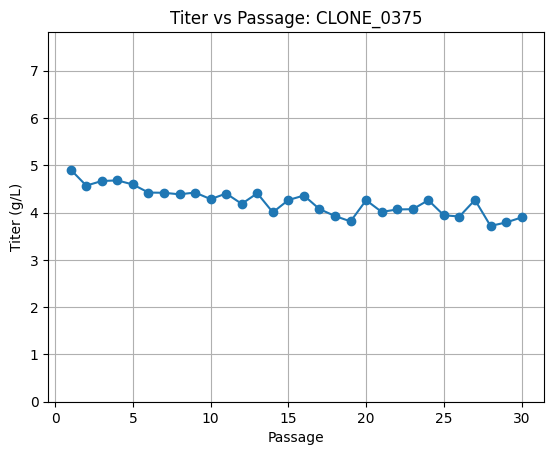

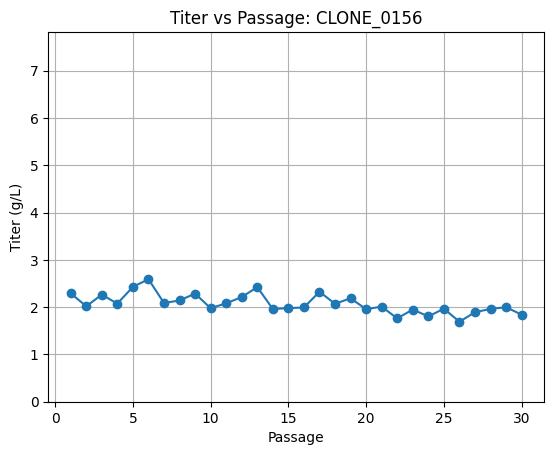

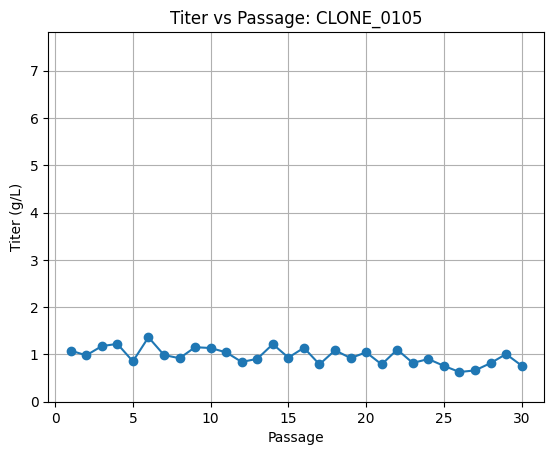

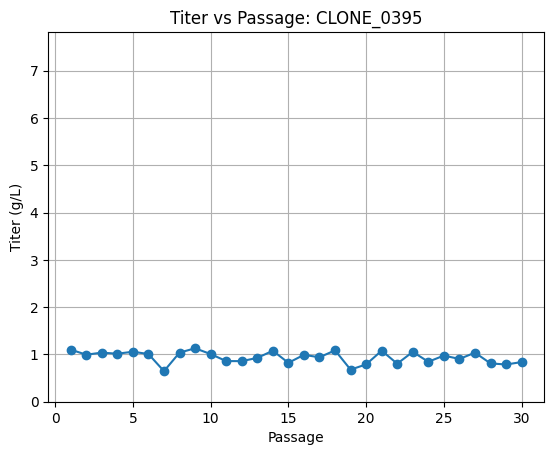

In [6]:
# 5) Titer vs passage (productivity trend) — fixed y-axis using global 1%–99% quantiles
# This makes it easier to compare multiple clones on the same scale while ignoring extreme outliers.

# 1) Compute global y-limits for titer using 1% and 99% quantiles (robust to outliers)
titer_all = assay[assay["assay_type"] == "titer"]["value"]

q01 = titer_all.quantile(0.01)
q99 = titer_all.quantile(0.99)

# add a small padding so curves don't touch plot borders
pad = 0.05 * (q99 - q01)
ymin_fixed = max(0.0, q01 - pad)
ymax_fixed = q99 + pad

print(f"Fixed y-axis (titer) using 1%–99% quantiles: {ymin_fixed:.3f} to {ymax_fixed:.3f} g/L")

# 2) Plot each sampled clone with the same y-axis range
for cid in sample_clones:
    df = assay[(assay["clone_id"] == cid) & (assay["assay_type"] == "titer")].sort_values("passage_number")
    plt.figure()
    plt.plot(df["passage_number"], df["value"], marker="o")
    plt.title(f"Titer vs Passage: {cid}")
    plt.xlabel("Passage")
    plt.ylabel("Titer (g/L)")
    plt.ylim(ymin_fixed, ymax_fixed)  # ✅ fixed y-axis for comparability
    plt.grid(True)
    plt.show()

## Comparison all plots at once

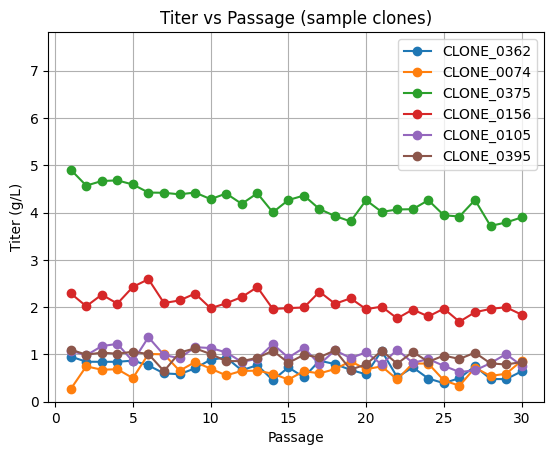

In [7]:
# Optional: overlay plot for easier comparison across clones (same fixed y-axis)

plt.figure()
for cid in sample_clones:
    df = assay[(assay["clone_id"] == cid) & (assay["assay_type"] == "titer")].sort_values("passage_number")
    plt.plot(df["passage_number"], df["value"], marker="o", label=cid)

plt.title("Titer vs Passage (sample clones)")
plt.xlabel("Passage")
plt.ylabel("Titer (g/L)")
plt.ylim(ymin_fixed, ymax_fixed)
plt.grid(True)
plt.legend()
plt.show()

## 6) VCD & Viability vs passage (growth and cell health)

VCD (Viable Cell Density) and viability are typical upstream process readouts (e.g., Vi-CELL).

In this synthetic model we expect:
- VCD/viability may improve over passages as cells adapt and expression burden decreases.
- Trends vary by clone due to different latent states and batch effects

Fixed y-axis (VCD) using 1%–99% quantiles: 3869082 to 18314917 cells/mL
Fixed y-axis (Viability) using 1%–99% quantiles: 89.0 to 100.0 %


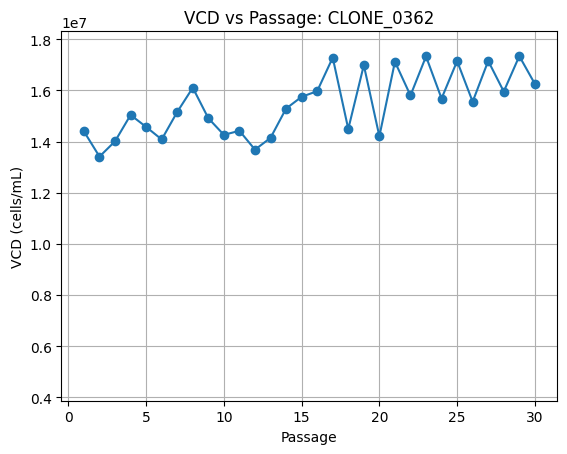

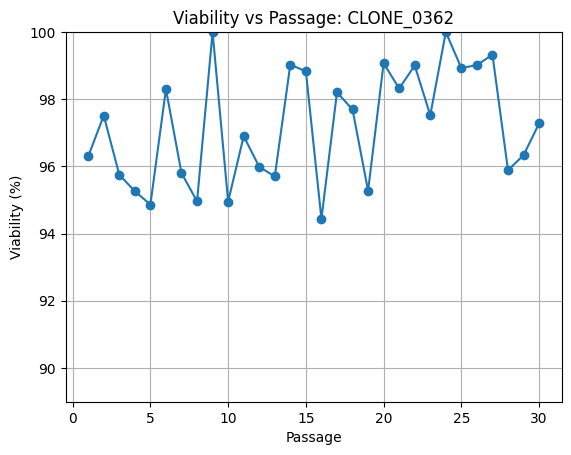

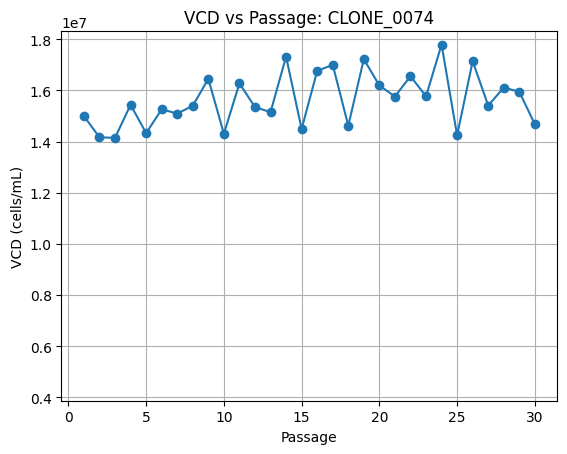

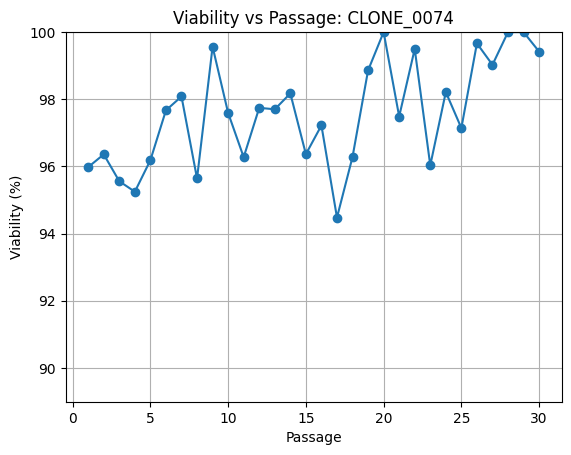

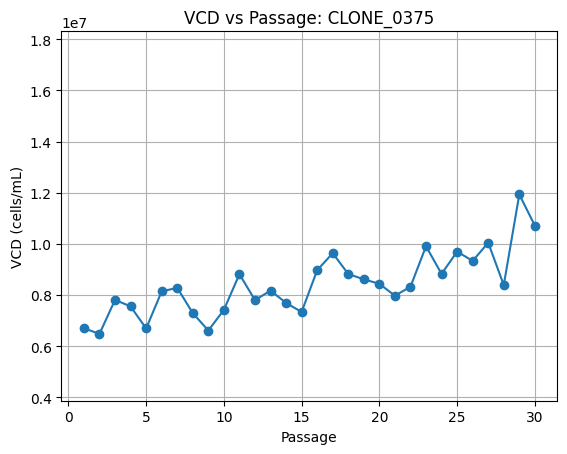

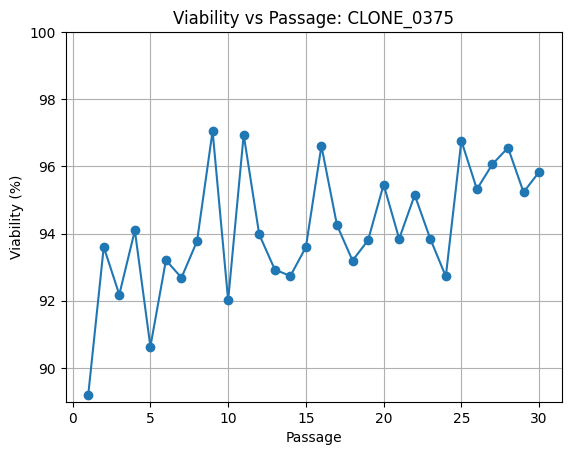

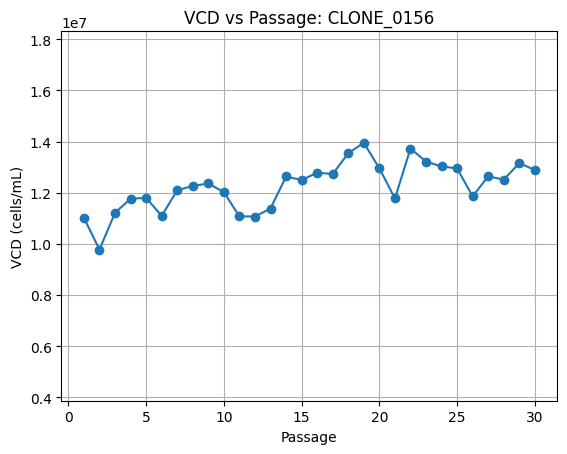

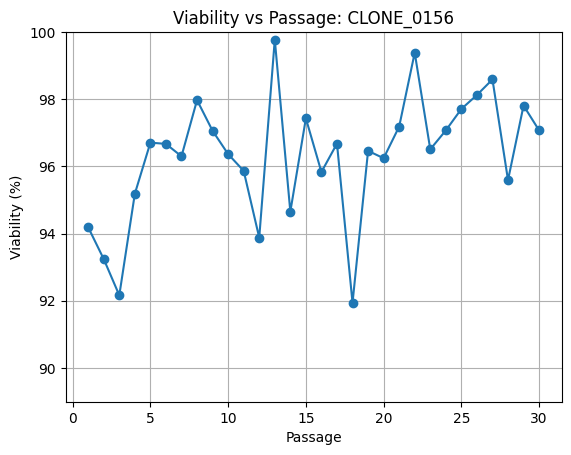

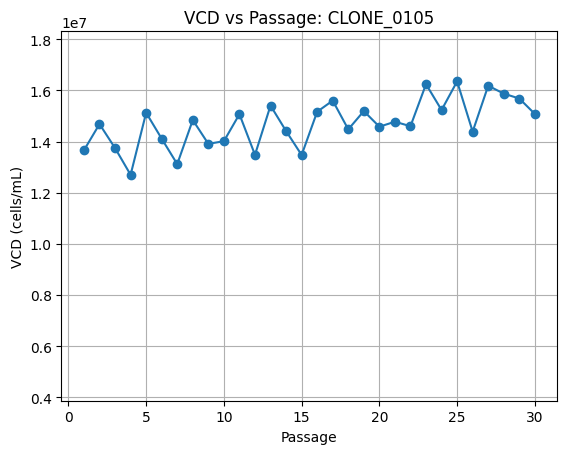

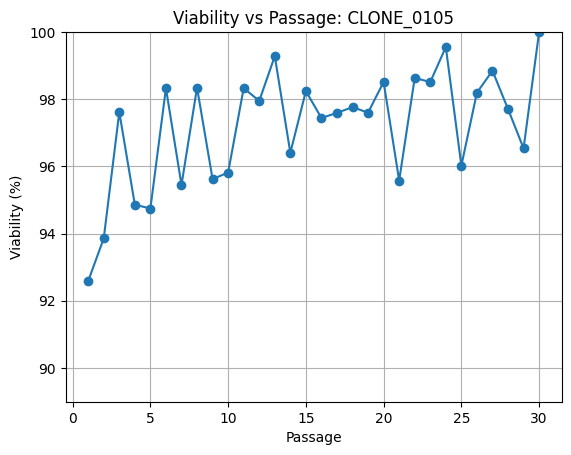

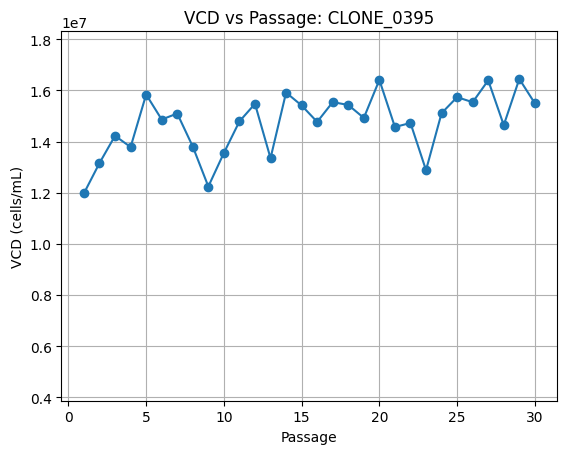

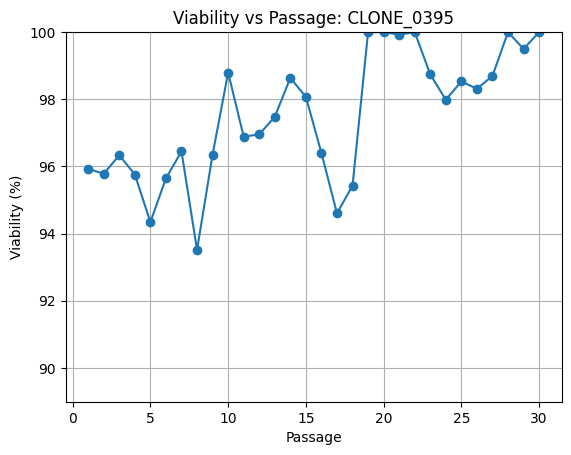

In [8]:
# 6) VCD & Viability vs passage — fixed y-axis using global 1%–99% quantiles
# This makes it easier to compare multiple clones on the same scale while ignoring extreme outliers.

# --- Compute global y-limits for VCD (1%–99%) ---
vcd_all = assay[assay["assay_type"] == "vcd"]["value"]
vcd_q01 = vcd_all.quantile(0.01)
vcd_q99 = vcd_all.quantile(0.99)
vcd_pad = 0.05 * (vcd_q99 - vcd_q01)
vcd_ymin = max(0.0, vcd_q01 - vcd_pad)
vcd_ymax = vcd_q99 + vcd_pad

print(f"Fixed y-axis (VCD) using 1%–99% quantiles: {vcd_ymin:.0f} to {vcd_ymax:.0f} cells/mL")

# --- Compute global y-limits for Viability (1%–99%) ---
viab_all = assay[assay["assay_type"] == "viability"]["value"]
viab_q01 = viab_all.quantile(0.01)
viab_q99 = viab_all.quantile(0.99)
viab_pad = 0.05 * (viab_q99 - viab_q01)
viab_ymin = max(0.0, viab_q01 - viab_pad)
viab_ymax = min(100.0, viab_q99 + viab_pad)  # viability is naturally bounded by 0–100

print(f"Fixed y-axis (Viability) using 1%–99% quantiles: {viab_ymin:.1f} to {viab_ymax:.1f} %")

# --- Plot VCD and Viability for each sampled clone using fixed y-limits ---
for cid in sample_clones:
    df_vcd = assay[(assay["clone_id"] == cid) & (assay["assay_type"] == "vcd")].sort_values("passage_number")
    df_viab = assay[(assay["clone_id"] == cid) & (assay["assay_type"] == "viability")].sort_values("passage_number")

    # VCD plot
    plt.figure()
    plt.plot(df_vcd["passage_number"], df_vcd["value"], marker="o")
    plt.title(f"VCD vs Passage: {cid}")
    plt.xlabel("Passage")
    plt.ylabel("VCD (cells/mL)")
    plt.ylim(vcd_ymin, vcd_ymax)  # fixed y-axis
    plt.grid(True)
    plt.show()

    # Viability plot
    plt.figure()
    plt.plot(df_viab["passage_number"], df_viab["value"], marker="o")
    plt.title(f"Viability vs Passage: {cid}")
    plt.xlabel("Passage")
    plt.ylabel("Viability (%)")
    plt.ylim(viab_ymin, viab_ymax)  # ✅ fixed y-axis (still within 0–100)
    plt.grid(True)
    plt.show()

## 7) Aggregation vs passage (qaulity proxy)

Aggregation is used as a simplified quality metric proxy (SEC-HPLC-like behavior).

In the simulator, aggregation increases when:
- intrinsic quality potential is lower
- stress is higher

This helps create realistic productivity-quality tradeoffs for ML experiments.

Fixed y-axis (Aggregation) using 1%–99% quantiles: 0.00 to 12.38 %


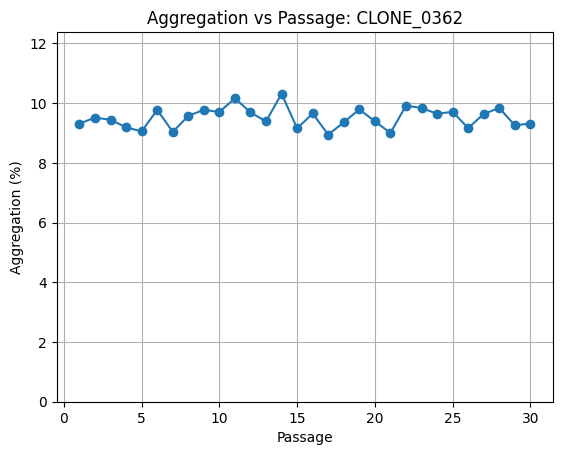

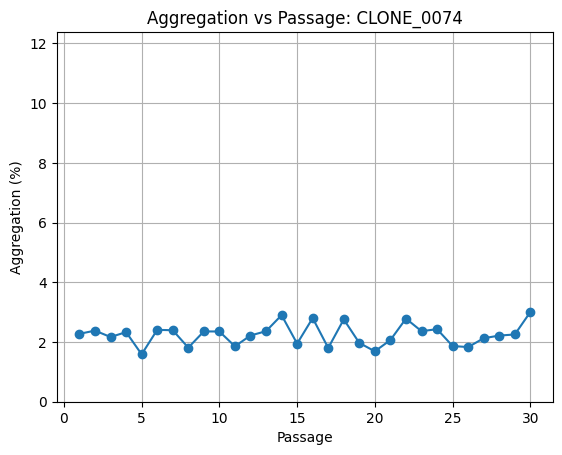

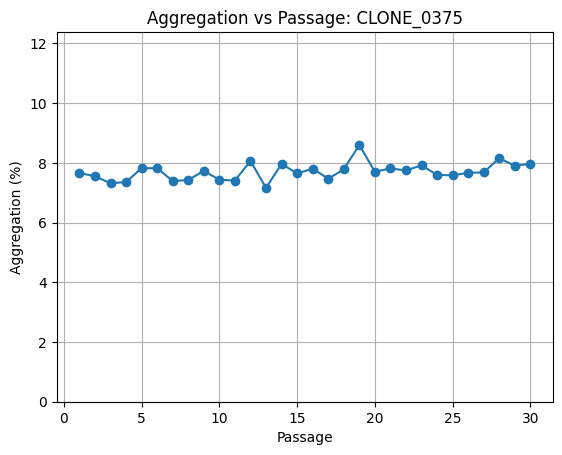

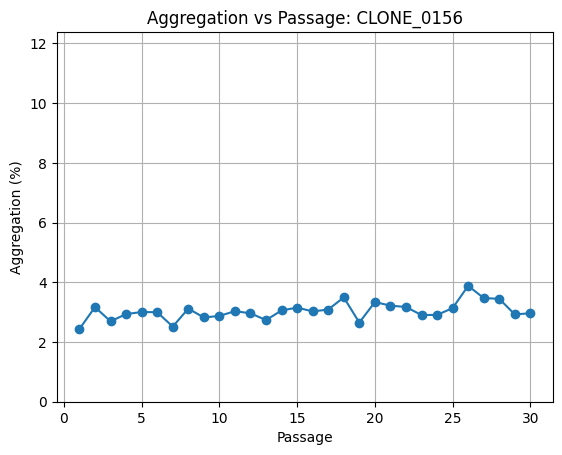

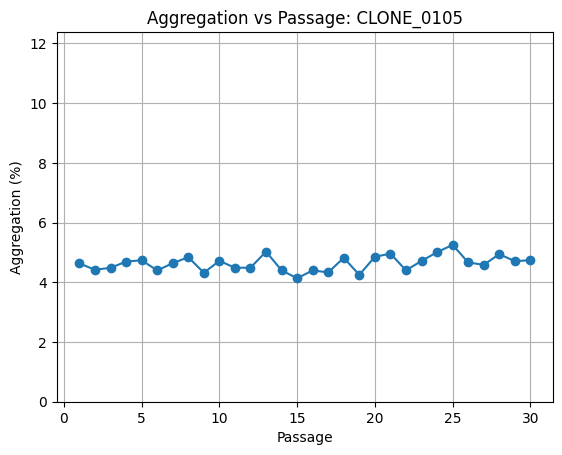

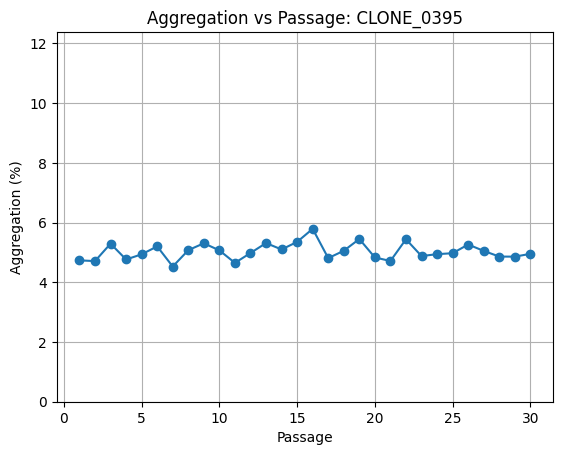

In [9]:
# 7) Aggregation vs passage (quality proxy) — fixed y-axis using global 1%–99% quantiles
# Aggregation is a simplified quality proxy (SEC-HPLC-like behavior).

agg_all = assay[assay["assay_type"] == "aggregation"]["value"]
agg_q01 = agg_all.quantile(0.01)
agg_q99 = agg_all.quantile(0.99)
agg_pad = 0.05 * (agg_q99 - agg_q01)

agg_ymin = max(0.0, agg_q01 - agg_pad)
agg_ymax = min(100.0, agg_q99 + agg_pad)  # aggregation is naturally bounded by 0–100

print(f"Fixed y-axis (Aggregation) using 1%–99% quantiles: {agg_ymin:.2f} to {agg_ymax:.2f} %")

for cid in sample_clones:
    df = assay[(assay["clone_id"] == cid) & (assay["assay_type"] == "aggregation")].sort_values("passage_number")
    plt.figure()
    plt.plot(df["passage_number"], df["value"], marker="o")
    plt.title(f"Aggregation vs Passage: {cid}")
    plt.xlabel("Passage")
    plt.ylabel("Aggregation (%)")
    plt.ylim(agg_ymin, agg_ymax)  # fixed y-axis
    plt.grid(True)
    plt.show()

## 8) Inspect stability labels

The 'stability_test' table stores a stability outcome per clone.
We use a robust label (early vs late averate titer drop) to reduce sensitivity to single-passage noise.

In [10]:
stb = pd.read_sql_query("SELECT * FROM stability_test", conn)
stb.describe()

,start_passage,end_passage,productivity_drop_pct
count,500.0,500.0,500.000000
mean,1.0,30.0,0.193453
std,0.0,0.0,0.124071
min,1.0,30.0,-0.541665
25%,1.0,30.0,0.124572
50%,1.0,30.0,0.200021
75%,1.0,30.0,0.267370
max,1.0,30.0,0.562787


In [11]:
stb = pd.read_sql_query("""
SELECT stability_id, clone_id, start_passage, end_passage, productivity_drop_pct, metric_type
FROM stability_test
""", conn)

stb.describe()

,start_passage,end_passage,productivity_drop_pct
count,500.0,500.0,500.000000
mean,1.0,30.0,0.193453
std,0.0,0.0,0.124071
min,1.0,30.0,-0.541665
25%,1.0,30.0,0.124572
50%,1.0,30.0,0.200021
75%,1.0,30.0,0.267370
max,1.0,30.0,0.562787


## 9) Plot Stability label distribution

This histogram sohws how stability outcomes are distributed across clones.
We expect a broad distribution where:
- values near 0 indicate stable clones.
- higher values indicate unstable clones (larger productivity drop)

Fixed x-axis (stability drop) using 1%–99% quantiles: 0.000 to 0.485


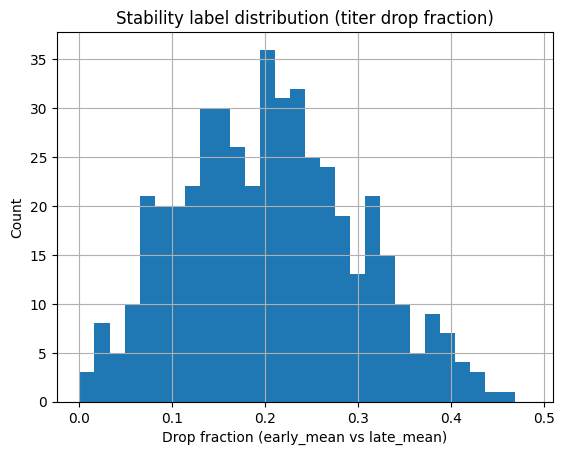

In [12]:
# 9) Stability histogram — fixed x-axis using global 1%–99% quantiles

drop = stb["productivity_drop_pct"].dropna()

q01 = drop.quantile(0.01)
q99 = drop.quantile(0.99)
pad = 0.05 * (q99 - q01)

xmin = max(0.0, q01 - pad)
xmax = min(1.0, q99 + pad)  # drop fraction is naturally bounded ~[0,1]

print(f"Fixed x-axis (stability drop) using 1%–99% quantiles: {xmin:.3f} to {xmax:.3f}")

plt.figure()
plt.hist(drop, bins=30, range=(xmin, xmax))
plt.title("Stability label distribution (titer drop fraction)")
plt.xlabel("Drop fraction (early_mean vs late_mean)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

## 10) Early productivity vs stability relationship (optional)

This scatter plot checks how early productivity (mean titer in early passages) relates to stability (late drop).
In real CLD, high early productivity does not always guarantee long-term stability.

Scatter x-axis (early mean titer) fixed to: 0.00–8.31 g/L
Scatter y-axis (drop fraction) fixed to: 0.00–0.49


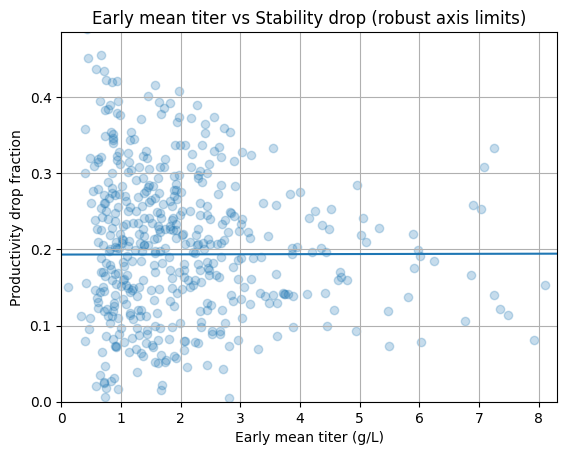

,early_mean_titer,productivity_drop_pct
early_mean_titer,1.000000,0.002102
productivity_drop_pct,0.002102,1.000000


In [13]:
# 10) Early mean titer vs Stability drop — improved scatter plot (robust axes + trend line)

early_max = 5

titer_df = assay[assay["assay_type"] == "titer"].copy()

early_mean = (
    titer_df[titer_df["passage_number"] <= early_max]
    .groupby("clone_id")["value"]
    .mean()
    .rename("early_mean_titer")
    .reset_index()
)

merged = early_mean.merge(
    stb[["clone_id", "productivity_drop_pct"]],
    on="clone_id",
    how="inner"
).dropna()

# --- Robust axis limits using 1%–99% quantiles ---
x_q01, x_q99 = merged["early_mean_titer"].quantile([0.01, 0.99])
y_q01, y_q99 = merged["productivity_drop_pct"].quantile([0.01, 0.99])

x_pad = 0.05 * (x_q99 - x_q01)
y_pad = 0.05 * (y_q99 - y_q01)

x_min = max(0.0, x_q01 - x_pad)
x_max = x_q99 + x_pad

y_min = max(0.0, y_q01 - y_pad)
y_max = min(1.0, y_q99 + y_pad)  # drop fraction naturally ~[0,1]

print(f"Scatter x-axis (early mean titer) fixed to: {x_min:.2f}–{x_max:.2f} g/L")
print(f"Scatter y-axis (drop fraction) fixed to: {y_min:.2f}–{y_max:.2f}")

# --- Scatter plot ---
plt.figure()
plt.scatter(merged["early_mean_titer"], merged["productivity_drop_pct"], alpha=0.25)
plt.title("Early mean titer vs Stability drop (robust axis limits)")
plt.xlabel("Early mean titer (g/L)")
plt.ylabel("Productivity drop fraction")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.grid(True)

# --- Add a simple trend line (least squares) ---
# This is not a "model"—just a visual guide.
x = merged["early_mean_titer"].values
y = merged["productivity_drop_pct"].values
m, b = np.polyfit(x, y, 1)
xs = np.linspace(x_min, x_max, 200)
ys = m * xs + b
plt.plot(xs, ys)

plt.show()

# Correlation (for reference)
merged[["early_mean_titer", "productivity_drop_pct"]].corr(numeric_only=True)

## 11) Batch effect check (optional)

Batch effects simulate systematic run-to-run drift (operator/day/platform effects).
We check whether mean titer shifts slightly across batches.

Fixed y-axis (mean titer by batch) using 1%–99% quantiles: 1.619–2.139 g/L


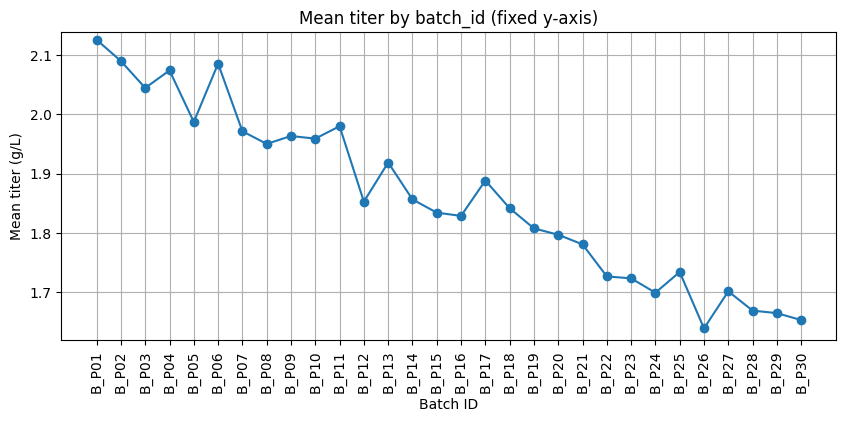

,batch_id,value
0,B_P01,2.126238
1,B_P02,2.090298
2,B_P03,2.044819
3,B_P04,2.074439
4,B_P05,1.987329


In [14]:
# 11) Batch effect check — mean titer by batch_id with fixed y-axis (1%–99%)

batch_titer = (
    assay[assay["assay_type"] == "titer"]
    .groupby("batch_id")["value"]
    .mean()
    .reset_index()
    .sort_values("batch_id")
)

# robust y-axis limits from 1%–99% quantiles (across batch means)
q01, q99 = batch_titer["value"].quantile([0.01, 0.99])
pad = 0.05 * (q99 - q01)

ymin = max(0.0, q01 - pad)
ymax = q99 + pad

print(f"Fixed y-axis (mean titer by batch) using 1%–99% quantiles: {ymin:.3f}–{ymax:.3f} g/L")

plt.figure(figsize=(10, 4))
plt.plot(batch_titer["batch_id"], batch_titer["value"], marker="o")
plt.xticks(rotation=90)
plt.title("Mean titer by batch_id (fixed y-axis)")
plt.xlabel("Batch ID")
plt.ylabel("Mean titer (g/L)")
plt.ylim(ymin, ymax)
plt.grid(True)
plt.show()

batch_titer.head()

## 12) Close database connection

Good practice: close the SQLite connection when the notebook is done.

In [12]:
conn.close()
print("DB connection closed.")

DB connection closed.


### Summary

- The synthetic CLD dataset is structurally correct and biologically plausible.
- Productivity, growth, viability, and quality show realistic passage-dependent behavior.
- Stability lables are meaningful and suitable as ML targets.
- Batch effects exist but do not overwhelm biological signals.